# Predicting precipitation in Vancouver

by Dan Zhang, Doris (Yun Yi) Cai, Hayley (Yi) Han & Sivakorn (Oak) Chong 2023/11/18

In [1]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import altair as alt

import numpy as np
import pandas as pd

# For model training (classification)
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from datetime import datetime as dt

# For regression
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV


# Summary

Our project is to build a classification model to predict if there's precipitation in a day (True or False) and a regression model to predict the amount of precipitation, based on features of temperature, wind speed, direction, shortwave radiation and evapotranspiration. The best classification model in our training and testing process is SVC-RBF with hyperparameter C=10.0. It yields the best test score of 0.8625 and f1-score of 0.87 on the positive class (there's precipitation) when generalizes to the unseen data. This is a pretty high accuracy to predict whether there's rain on a particular day. The best regression model trained with the same features to predict the amount of precipitaiton is SVR with gamma=0.1 and C=1000. It produces the best score on the unseen test data of 0.6993. The accuracy is adequate. More study could be done to improve the regression model.

# 1. Introduction 

Prediction of daily precipitation is a fundamental aspect of meteorological studies [1]. Accurate precipitation prediction is crucial for agriculture, water resources management, as well as daily activities of people. Specifically, in a geographically and climatically diverse region like Vancouver, predicting precipitation is vital for people to prepare for extreme weather events, reducing hazards and minimizing property damage.

In this project, we aim to predict the occurrence and the amount of daily precipitation in Vancouver using machine learning (ML) classification methods [2]. Specifically, our analysis utilizes a dataset containing daily precipitation information in Vancouver from 1990 to the present (i.e., 6 Nov, 2023). This dataset, sourced from Open-Meteo’s Historical Weather API [3], includes a number of parameters relevant to precipitation prediction. 
Key parameters include month, daily temperature measures, wind speeds, wind direction, shortwave radiation, and ET₀ reference evapotranspiration. Specifically, shortwave radiation represents the sum of solar energy received in a day; ET₀ reference evapotranspiration provides an indication of the atmospheric demand for moisture (i.e., higher relative humidity reduces ET₀ ); and month is also included as a variable since it accounts for the seasonal variations in precipitation [4]. This project may contributes insights into accurate forecast of the precipitation in Vancouver.

# 2. Methods & Results

## 2.1 Data

The dataset used in this project was sourced from Open-Meteo’s Historical Weather API [3], which can be found [here](https://open-meteo.com/en/docs/historical-weather-api#latitude=49.2497&longitude=-123.1193&hourly=weather_code&daily=weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto).

### 2.1.1 Loads data from the original source on the web & data wrangling

In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [3]:
VAN_LAT = 49.2497
VAN_LONG = -123.1193
START_DATE = "1990-01-01"
END_DATE = (datetime.now() - timedelta(days = 7)).strftime('%Y-%m-%d')
RETRIEVE_COLS = ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]

In [4]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": VAN_LAT,
	"longitude": VAN_LONG,
	"start_date": START_DATE,
	"end_date": END_DATE,
	"daily": RETRIEVE_COLS,
    "timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 49.244285583496094°E -123.13357543945312°N
Elevation 73.0 m asl
Timezone b'America/Vancouver' b'PST'
Timezone difference to GMT+0 -28800 s


In [5]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
daily_sunrise = daily.Variables(7).ValuesAsNumpy()
daily_sunset = daily.Variables(8).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(9).ValuesAsNumpy()
daily_rain_sum = daily.Variables(10).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(11).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(12).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(13).ValuesAsNumpy()
daily_wind_gusts_10m_max = daily.Variables(14).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(15).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(16).ValuesAsNumpy()
daily_et0_fao_evapotranspiration = daily.Variables(17).ValuesAsNumpy()

In [6]:
daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s").strftime('%Y-%m-%d'),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s").strftime('%Y-%m-%d'),
	freq = pd.Timedelta(days = 1),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

In [7]:
df_van_weather = pd.DataFrame(data = daily_data)
df_van_weather = df_van_weather.set_index('date')
display(df_van_weather)

weather_code  temperature_2m_max  temperature_2m_min  \
date                                                               
1990-01-01          51.0            5.709500              2.0095   
1990-01-02          71.0            3.059500              0.0095   
1990-01-03          73.0            4.409500              1.9595   
1990-01-04          61.0            7.359500              3.2095   
1990-01-05          63.0            8.359500              3.6595   
...                  ...                 ...                 ...   
2023-11-07          61.0            9.280500              5.4805   
2023-11-08          51.0            8.330501              5.5305   
2023-11-09          61.0            9.680500              4.0805   
2023-11-10          63.0            8.080501              5.0305   
2023-11-11          63.0           10.530500              3.9305   

            temperature_2m_mean  apparent_temperature_max  \
date                                                        
1990-01-01             3.903250                  1.759364   
1990-01-02             1.959500                 -0.347375   
1990-01-03             2.934500                  1.055596   
1990-01-04             4.917833                  3.778481   
1990-01-05             5.892833                  4.432674   
...                         ...                       ...   
2023-11-07             8.451334                  7.843756   
2023-11-08             7.061750                  5.872250   
2023-11-09             6.876333                  7.539673   
2023-11-10             7.068000                  5.018043   
2023-11-11             8.059667                  7.758933   

            apparent_temperature_min  apparent_temperature_mean  sunrise  \
date                                                                       
1990-01-01                 -2.227180                   0.155060        0   
1990-01-02                 -2.789511                  -1.547469        0   
1990-01-03                 -1.572106                  -0.585330        0   
1990-01-04                  0.573077                   1.792292        0   
1990-01-05                  0.000019                   2.062605        0   
...                              ...                        ...      ...   
2023-11-07                  2.625087                   4.601493        0   
2023-11-08                  2.795826                   4.471347        0   
2023-11-09                  1.655607                   4.298377        0   
2023-11-10                  2.077088                   3.901591        0   
2023-11-11                  1.031771                   4.908400        0   

            sunset  precipitation_sum   rain_sum  snowfall_sum  \
date                                                             
1990-01-01       0           1.600000   1.600000          0.00   
1990-01-02       0           1.000000   0.700000          0.21   
1990-01-03       0          11.400002  10.600001          0.56   
1990-01-04       0          12.599999  12.599999          0.00   
1990-01-05       0          17.699999  17.699999          0.00   
...            ...                ...        ...           ...   
2023-11-07       0           2.900000   2.900000          0.00   
2023-11-08       0           1.300000   1.300000          0.00   
2023-11-09       0           7.200000   7.200000          0.00   
2023-11-10       0          23.000000  23.000000          0.00   
2023-11-11       0          26.299999  26.299999          0.00   

            precipitation_hours  wind_speed_10m_max  wind_gusts_10m_max  \
date                                                                      
1990-01-01                  7.0           18.250259           35.279999   
1990-01-02                  5.0           12.261158           28.799999   
1990-01-03                 24.0           17.555307           34.560001   
1990-01-04                 14.0           18.806337           38.160000   
1990-01-05                 17.0    

In [8]:
## Save data into csv file.
# df_van_weather.to_csv(f'van_weather_{START_DATE}_{END_DATE}.csv')

### 2.1.2 Brief description of the data set

Each row in the data set represents daily precipitation information in Vancouver with  various parameters relevant to precipitation. Parameters included in the following analysis are listed with a short description as follows.

In [9]:
# Load the data
precipit_df = pd.read_csv("data/van_weather_1990-01-01_2023-11-06.csv"
                         ).drop(columns = ['sunrise',
                                           'sunset',
                                           'weather_code',
                                           'rain_sum',
                                           'snowfall_sum',
                                           'precipitation_hours'])
precipit_df.head()

date  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0  1990-01-01              5.7095              2.0095             3.903249   
1  1990-01-02              3.0595              0.0095             1.959500   
2  1990-01-03              4.4095              1.9595             2.934500   
3  1990-01-04              7.3595              3.2095             4.917833   
4  1990-01-05              8.3595              3.6595             5.892833   

   apparent_temperature_max  apparent_temperature_min  \
0                  1.759364                 -2.227180   
1                 -0.347375                 -2.789511   
2                  1.055596                 -1.572106   
3                  3.778481                  0.573077   
4                  4.432674                  0.000019   

   apparent_temperature_mean  precipitation_sum  wind_speed_10m_max  \
0                   0.155060           1.600000           18.250260   
1                  -1.547468           1.000000           12.261158   
2                  -0.585330          11.400002           17.555307   
3                   1.792292          12.599999           18.806337   
4                   2.062605          17.699999           32.919827   

   wind_gusts_10m_max  wind_direction_10m_dominant  shortwave_radiation_sum  \
0           35.280000                    222.90671                     4.09   
1           28.800000                    171.74966                     3.29   
2           34.560000                    141.70381                     1.89   
3           38.160000                    162.86450                     2.43   
4           64.439995                    159.80486                     0.64   

   et0_fao_evapotranspiration  
0                    0.504341  
1                    0.467342  
2                    0.201307  
3                    0.277709  
4                    0.168201

#### Column description
- `date`: date of the record
- `temperature_2m_max`: Maximum daily air temperature at 2 meters above ground (°C)
- `temperature_2m_min`: Minimum daily air temperature at 2 meters above ground (°C)
- `temperature_2m_mean`: Mean daily air temperature at 2 meters above ground (°C)
- `apparent_temperature_max`: Maximum daily apparent temperature (°C)
- `apparent_temperature_min`: Minimum daily apparent temperature (°C)
- `apparent_temperature_mean`: Mean daily apparent temperature (°C)
- `precipitation_sum`: Sum of daily precipitation (including rain, showers and snowfall) (mm)
- `wind_speed_10m_max`: Maximum wind speed on a day (km/h)
- `wind_gusts_10m_max`: Maximum wind gusts on a day (km/h)
- `wind_direction_10m_dominant`: Dominant wind direction (°)
- `shortwave_radiation_sum`: The sum of solar radiaion on a given day in Megajoules (MJ/m²)
- `et0_fao_evapotranspiration`: Daily sum of ET₀ Reference Evapotranspiration of a well watered grass field (mm)

## 2.2. Exploratory data analysis 

### 2.2.1 Creating a classification target column

Pulling in the data and creating a classification target column `is_precipitation` based on sum of daily precipitation `precipitation_sum`. If `precipitation_sum` is greater than 0.01, we assign True to `is_precipitation`, otherwise False. The reason we use 0.01 as the threshold for assigning the class is because 0.01 is insignificant and can be used to avoid rounding issue. `precipittion_sum` is the regression target column.

In [10]:
precipit_df['is_precipitation'] = precipit_df['precipitation_sum'] > 0.01

precipit_df['date'] = pd.to_datetime(precipit_df['date'])
precipit_df['month'] = precipit_df['date'].dt.month

# precipit_df['month'] = precipit_df['date'].str[5:7].astype(int)
precipit_df = precipit_df.drop(columns='date')
precipit_df

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0                  5.7095              2.0095             3.903249   
1                  3.0595              0.0095             1.959500   
2                  4.4095              1.9595             2.934500   
3                  7.3595              3.2095             4.917833   
4                  8.3595              3.6595             5.892833   
...                   ...                 ...                  ...   
12358             13.0305              7.6305             9.984666   
12359             11.7305              7.3305             9.782582   
12360             14.1805              9.2805            11.647167   
12361             11.7805              8.1305             9.651333   
12362             11.1305              8.6805             9.490916   

       apparent_temperature_max  apparent_temperature_min  \
0                      1.759364                 -2.227180   
1                     -0.347375                 -2.789511   
2                      1.055596                 -1.572106   
3                      3.778481                  0.573077   
4                      4.432674                  0.000019   
...                         ...                       ...   
12358                 11.770529                  5.137917   
12359                  9.703583                  5.214563   
12360                 13.198673                  7.234596   
12361                  9.457133                  5.149190   
12362                  9.251951                  6.635953   

       apparent_temperature_mean  precipitation_sum  wind_speed_10m_max  \
0                       0.155060           1.600000           18.250260   
1                      -1.547468           1.000000           12.261158   
2                      -0.585330          11.400002           17.555307   
3                       1.792292          12.599999           18.806337   
4                       2.062605          17.699999           32.919827   
...                          ...                ...                 ...   
12358                   7.995744          53.900005           21.243050   
12359                   7.581160           4.700000           20.469410   
12360                   9.908348          32.999996           21.437386   
12361                   6.866447          41.600000           22.751316   
12362                   7.265777          14.000000           16.099690   

       wind_gusts_10m_max  wind_direction_10m_dominant  \
0               35.280000                   222.906710   
1               28.800000                   171.749660   
2               34.560000                   141.703810   
3               38.160000                   162.864500   
4               64.439995                   159.804860   
...                   ...                          ...   
12358           34.920000                    86.653230   
12359           33.839996                    80.872470   
12360           38.880000                   106.656235   
12361           36.000000                    81.606230   
12362           25.199999                    82.658380   

       shortwave_radiation_sum  et0_fao_evapotranspiration  is_precipitation  \
0                         4.09                    0.504341              True   
1                         3.29                    0.467342              True   
2                         1.89                    0.201307              True   
3                         2.43                    0.277709              True   
4                         0.64                    0.168201              True   
...                        ...                         ...               ...   
12358                     3.12                    0.478838              True   
12359                     3.09                    0.572418              True   
12360                     3.54                    0.508575              True   
12361                     2.90     

### 2.2.2 Inspect the data

Using `.info()` to examine the data, there no missing value in each column. All features are numeric type.

In [11]:
precipit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12363 entries, 0 to 12362
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temperature_2m_max           12363 non-null  float64
 1   temperature_2m_min           12363 non-null  float64
 2   temperature_2m_mean          12363 non-null  float64
 3   apparent_temperature_max     12363 non-null  float64
 4   apparent_temperature_min     12363 non-null  float64
 5   apparent_temperature_mean    12363 non-null  float64
 6   precipitation_sum            12363 non-null  float64
 7   wind_speed_10m_max           12363 non-null  float64
 8   wind_gusts_10m_max           12363 non-null  float64
 9   wind_direction_10m_dominant  12363 non-null  float64
 10  shortwave_radiation_sum      12363 non-null  float64
 11  et0_fao_evapotranspiration   12363 non-null  float64
 12  is_precipitation             12363 non-null  bool   
 13  month           

### 2.2.3 Understanding the data

Plotting the distribution of each numeric columns in below. The temperature features are more like a normal distribution. Wind speed, radiation and evapotranspiration are slightly right-skewed. The wind direction feature seems to be bimodal.

In [12]:
alt.data_transformers.enable("vegafusion")

numeric_cols = precipit_df.select_dtypes(include=['number']).columns.tolist()

numeric_cols_hists = alt.Chart(precipit_df).mark_bar().encode(
    alt.X(alt.repeat()).type('quantitative').bin(maxbins=40),
        y='count()',
    ).properties(
        height=100,
        width=200
    ).repeat(
        numeric_cols,
        columns=4
    )

# Show the plot
numeric_cols_hists

alt.RepeatChart(...)

Figure 1. Distribution of all numeric features in the dataset.

In below correlation matrix, we notice that temperatue features are highly correlated with each other. We can just use one temperature parameter in our analysis. Here we choose to use `temperature_2m_mean`. Similarly, winds features are also highly correlated. Hence we decide to keep `wind_speed_10m_max` and drop the other one to avoid collinearity issue. 

In [13]:
precipit_df[numeric_cols].corr('spearman').style.background_gradient(cmap="gist_yarg")

Table 1. Correlation matrix between all numeric features in the dataset.

### 2.2.4 Select features for classification and further explore the relationship between the features of interest

We are dropping the temperature features that are highly correlated with `temperature_2m_mean` and the wind feature that are highly correlated to `wind_speed_10m_max`. After cleaning up the data, we are going to predict `precipitation_sum` and `is_precipitation` using the feature `temperature_2m_mean`, `wind_speed_10m_max`, `wind_direction_10m_dominant`, `shortwave_radiation_sum`, `et0_fao_evapotranspiration` and `month`.

In [14]:
precipit_df = precipit_df.drop(columns = ['temperature_2m_max',
                                          'temperature_2m_min',
                                          'apparent_temperature_max', 
                                          'apparent_temperature_min', 
                                          'apparent_temperature_mean',
                                          'wind_gusts_10m_max'])
precipit_df

temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0                 3.903249           1.600000           18.250260   
1                 1.959500           1.000000           12.261158   
2                 2.934500          11.400002           17.555307   
3                 4.917833          12.599999           18.806337   
4                 5.892833          17.699999           32.919827   
...                    ...                ...                 ...   
12358             9.984666          53.900005           21.243050   
12359             9.782582           4.700000           20.469410   
12360            11.647167          32.999996           21.437386   
12361             9.651333          41.600000           22.751316   
12362             9.490916          14.000000           16.099690   

       wind_direction_10m_dominant  shortwave_radiation_sum  \
0                       222.906710                     4.09   
1                       171.749660                     3.29   
2                       141.703810                     1.89   
3                       162.864500                     2.43   
4                       159.804860                     0.64   
...                            ...                      ...   
12358                    86.653230                     3.12   
12359                    80.872470                     3.09   
12360                   106.656235                     3.54   
12361                    81.606230                     2.90   
12362                    82.658380                     1.65   

       et0_fao_evapotranspiration  is_precipitation  month  
0                        0.504341              True      1  
1                        0.467342              True      1  
2                        0.201307              True      1  
3                        0.277709              True      1  
4                        0.168201              True      1  
...                           ...               ...    ...  
12358                    0.478838              True     11  
12359                    0.572418              True     11  
12360                    0.508575              True     11  
12361                    0.550135              True     11  
12362                    0.439529              True     11  

[12363 rows x 8 columns]

Plotting the scatter charts for each feature vs the regression target precipitation_sum to investigate if there is any pattern present. In preliminary investigation, we notice there is no pattern standing out for temperature, wind speed and wind direction. However, shortwave radiation and evapotranspiration shows strong negative correlation with the precipitation amount precipitation_sum. We also notice for month January, February, October, November and December. This is expected because there are more rain in winter in Vancouver.

In [15]:
interesting_cols = precipit_df.select_dtypes(include=['number']).columns.tolist()
interesting_cols.remove('precipitation_sum')

numeric_cols_vs_target_r = alt.Chart(precipit_df).mark_point().encode(
    x='precipitation_sum',
    y=alt.Y(alt.repeat()).type('quantitative'),
    color='is_precipitation'
    
).properties(
    height=200,
    width=300
).repeat(
    interesting_cols,
    columns=3
)

# Show the plot
numeric_cols_vs_target_r

alt.RepeatChart(...)

Figure 2. Relationship between the amount of precipitation with the features of interest.

Plotting a box plot for each feature vs the classification target `is_precipitation`. We notice `shortwave_radiation_sum` and `et0_fao_evapotranspiration` has different means for the False and True class. Radiation and evapotranspiration mean tends to be higher when there's no precipitation than when there's precipitation.

In [16]:
numeric_cols_vs_target_c = alt.Chart(precipit_df).mark_boxplot().encode(
    x='is_precipitation',
    y=alt.Y(alt.repeat()).type('quantitative')
).properties(
    height=200,
    width=300
).repeat(
    interesting_cols,
    columns=3
)

numeric_cols_vs_target_c

alt.RepeatChart(...)

Figure 3. Distribution of features of interest for different categories of precipitation (true or false).

## 2.3 Classification analysis

### 2.3.1 Splitting dateset
We are splitting up the cleaned data into 80% training set and 20% test set.

In [17]:
train_df, test_df = train_test_split(precipit_df, test_size=0.2, random_state=522)
train_df.shape

(9890, 8)

In [18]:
X_train = train_df.drop(columns=['precipitation_sum', 'is_precipitation'])
y_train_class, y_train_regress = train_df['is_precipitation'], train_df['precipitation_sum']

X_test = test_df.drop(columns=['precipitation_sum', 'is_precipitation'])
y_test_class, y_test_regress = test_df['is_precipitation'], test_df['precipitation_sum']

The proportion of samples labeled as True is similar to the proportion of the samples labeled as False.

In [19]:
y_train_class.value_counts(normalize=True)

is_precipitation
True     0.553488
False    0.446512
Name: proportion, dtype: float64

### 2.3.2 Column transformation

In [20]:
from datetime import datetime as dt

# Using ordinal encoding  or leaving the month as a number may not be the best representation of month. 
# Since month is a cyclical data, we get inspiration from this work and use cyclical encoding: 
# https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning
# This preprocessing does not break golden rule because the max value of months is 12 as per common knowledge. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

X_train = encode(X_train, 'month', 12)
X_test = encode(X_test, 'month', 12 )

In [21]:
X_train.columns

Index(['temperature_2m_mean', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration', 'month', 'month_sin', 'month_cos'],
      dtype='object')

In [22]:
from sklearn.compose import make_column_transformer

numeric_features = ['temperature_2m_mean', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration', 'month_sin', 'month_cos']

drop_features = ['month']
numeric_transformer = StandardScaler()

preprocess = make_column_transformer(
    (numeric_transformer, numeric_features),  # scaling on numeric features
    ("drop", drop_features)
)

### 2.3.3 Model selection

In [23]:
# We will evaluate a set of models for this project
models = {
    "dummy": DummyClassifier(random_state=522), 
    "Decision Tree": DecisionTreeClassifier(random_state=522),
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=522),
    "Logistic Regression": LogisticRegression(max_iter=2000, multi_class="ovr", random_state=522),
}

In [24]:
# Defining the function to calculate score for cross validation (credit to DSCI571)
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    print(out_col)
    return pd.Series(data=out_col, index=mean_scores.index)

def cross_val_model(model, X_train, y_train, classification_metrics):
    pipe = make_pipeline(preprocess, models[model])
    return pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True, scoring=classification_metrics)).agg(['mean']).round(3).T


In [25]:
cross_val_results = {}
classification_metrics = ["accuracy", "precision", "recall", "f1"]
for model_name in models.keys():
    model = models[model_name]
    pipe = make_pipeline(preprocess, model_name)
    cross_val_results[model_name] = cross_val_model(model_name, X_train, y_train_class, classification_metrics)   
    print("Done with", model_name)

results_df = pd.concat(
    cross_val_results,
    axis='columns'
)

results_df

Done with dummy
Done with Decision Tree
Done with KNN
Done with RBF SVM
Done with Logistic Regression


dummy Decision Tree    KNN RBF SVM Logistic Regression
                  mean          mean   mean    mean                mean
fit_time         0.002         0.040  0.004   0.410               0.009
score_time       0.003         0.005  0.036   0.162               0.003
test_accuracy    0.553         0.797  0.836   0.859               0.844
train_accuracy   0.553         1.000  0.885   0.863               0.845
test_precision   0.553         0.817  0.861   0.886               0.860
train_precision  0.553         1.000  0.904   0.889               0.862
test_recall      1.000         0.816  0.838   0.856               0.857
train_recall     1.000         1.000  0.887   0.860               0.857
test_f1          0.713         0.817  0.849   0.871               0.859
train_f1         0.713         1.000  0.895   0.874               0.859

Table 2. Scores of cross validation for different classifiers. 

Based on accuracy, test_recall, and test_precision, **RBF SVM** is the best performing model. We will take a look at it for future hyperparameter optimization.

### 2.3.4 Feature importance

Meanwhile, let us take a sidetrack and find out which features are important by looking at the feature importance via logistic regression. It is difficult to interpret feature importance of SVC fitted via RBF.

<Axes: ylabel='Feature'>

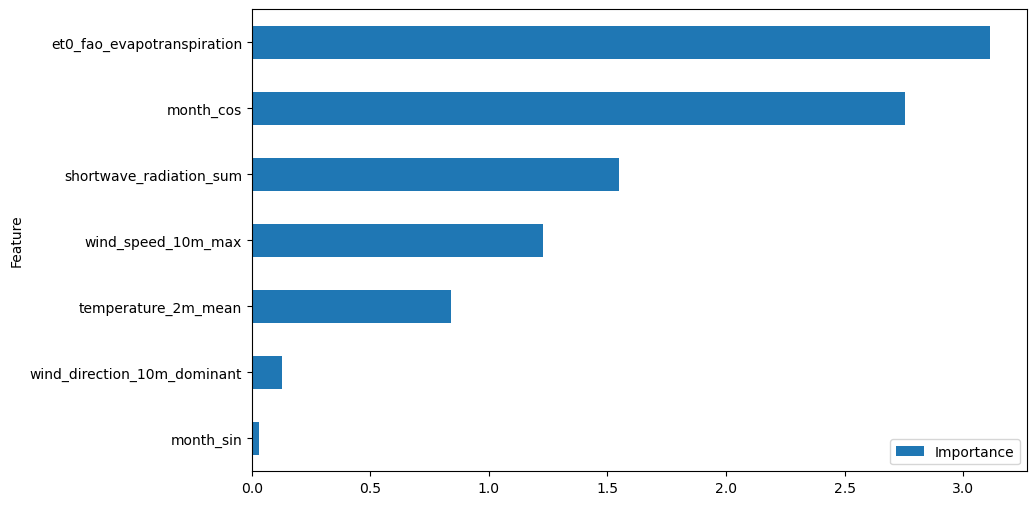

In [26]:
pipe = make_pipeline(preprocess, models["Logistic Regression"])
pipe.fit(X_train, y_train_class)

coefficients = pipe.named_steps['logisticregression'].coef_[0]

feature_importance = pd.DataFrame({'Feature': numeric_features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Figure 4. Feature importance obtained from the logistic regression model.

Month and `et0_fao_evapotranspiration` are the most important features.

### 2.3.5 Hyperparameter optimization for the best model
As shown below, our best Model is the one with C=10.0, since it gives highest test_score.

In [27]:
param_grid = {"svc__C": 10.0**np.arange(-3,3)}
svc_pipe = make_pipeline(preprocess, models['RBF SVM'])
grid_search = GridSearchCV(svc_pipe,param_grid=param_grid,n_jobs=-1,return_train_score=True)
grid_search.fit(X_train, y_train_class)
print(grid_search.best_params_)
C_best_value = grid_search.best_params_['svc__C']
opt_pipe = make_pipeline(preprocess, SVC(C=C_best_value, random_state = 522))
opt_pipe.fit(X_train, y_train_class)
opt_pipe.score(X_test, y_test_class)

{'svc__C': 10.0}


0.862515163768702

In [28]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_test_class, opt_pipe.predict(X_test), labels=[True,False]
    )
)

              precision    recall  f1-score   support

        True       0.89      0.86      0.87      1354
       False       0.84      0.87      0.85      1119

    accuracy                           0.86      2473
   macro avg       0.86      0.86      0.86      2473
weighted avg       0.86      0.86      0.86      2473



## 2.4 Regression analysis

### 2.4.1 Model selection

In [29]:
# All the features are numerical features to be standardized. Here, we will use standard scalar.
preprocess_reg = make_column_transformer(
    (numeric_transformer, numeric_features),  # scaling on numeric features
    ("drop", drop_features)
)

# We will evaluate a set of models for this project
regressor_models = {
    "Dummy Regressor": DummyRegressor(), 
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=522),
    "KNN Regressor": KNeighborsRegressor(),
    "SVR": SVR(),
    "Ridge": Ridge(random_state=522)
}

cv_results_reg = {}

for model_name, model in regressor_models.items():
    pipe = make_pipeline(preprocess_reg, model)
    cv_results_reg[model_name] = mean_std_cross_val_scores(pipe, X_train, y_train_regress, return_train_score=True)
    print("Done with", model_name)

results_df_reg = pd.DataFrame(cv_results_reg).T
results_df_reg

['0.002 (+/- 0.000)', '0.001 (+/- 0.000)', '-0.001 (+/- 0.002)', '0.000 (+/- 0.000)']
Done with Dummy Regressor
['0.044 (+/- 0.003)', '0.002 (+/- 0.001)', '0.393 (+/- 0.034)', '1.000 (+/- 0.000)']
Done with Decision Tree Regressor
['0.003 (+/- 0.000)', '0.010 (+/- 0.000)', '0.596 (+/- 0.029)', '0.729 (+/- 0.004)']
Done with KNN Regressor
['0.946 (+/- 0.009)', '0.316 (+/- 0.002)', '0.606 (+/- 0.025)', '0.609 (+/- 0.006)']
Done with SVR
['0.002 (+/- 0.000)', '0.001 (+/- 0.000)', '0.488 (+/- 0.018)', '0.488 (+/- 0.004)']
Done with Ridge


fit_time         score_time  \
Dummy Regressor          0.002 (+/- 0.000)  0.001 (+/- 0.000)   
Decision Tree Regressor  0.044 (+/- 0.003)  0.002 (+/- 0.001)   
KNN Regressor            0.003 (+/- 0.000)  0.010 (+/- 0.000)   
SVR                      0.946 (+/- 0.009)  0.316 (+/- 0.002)   
Ridge                    0.002 (+/- 0.000)  0.001 (+/- 0.000)   

                                 test_score        train_score  
Dummy Regressor          -0.001 (+/- 0.002)  0.000 (+/- 0.000)  
Decision Tree Regressor   0.393 (+/- 0.034)  1.000 (+/- 0.000)  
KNN Regressor             0.596 (+/- 0.029)  0.729 (+/- 0.004)  
SVR                       0.606 (+/- 0.025)  0.609 (+/- 0.006)  
Ridge                     0.488 (+/- 0.018)  0.488 (+/- 0.004)

Table 3. Scores of cross validation for different regressors. 

Based on the cross-validation results above

- Dummy Regressor: Not useful for predictions.
- Decision Tree Regressor: Overfits the data (good on training, poor on testing).
- KNN Regressor: Decent performance, but a bit of overfitting.
- SVR: Best performance, good at generalizing (similar scores on training and testing).
- Ridge: Moderate performance, good at generalizing but not as accurate as SVR or KNN.

Best Choice: SVR, because it has the highest accuracy and generalizes well, but it's a little bit slower.

### 2.4.2 Feature importance

<Axes: ylabel='Feature'>

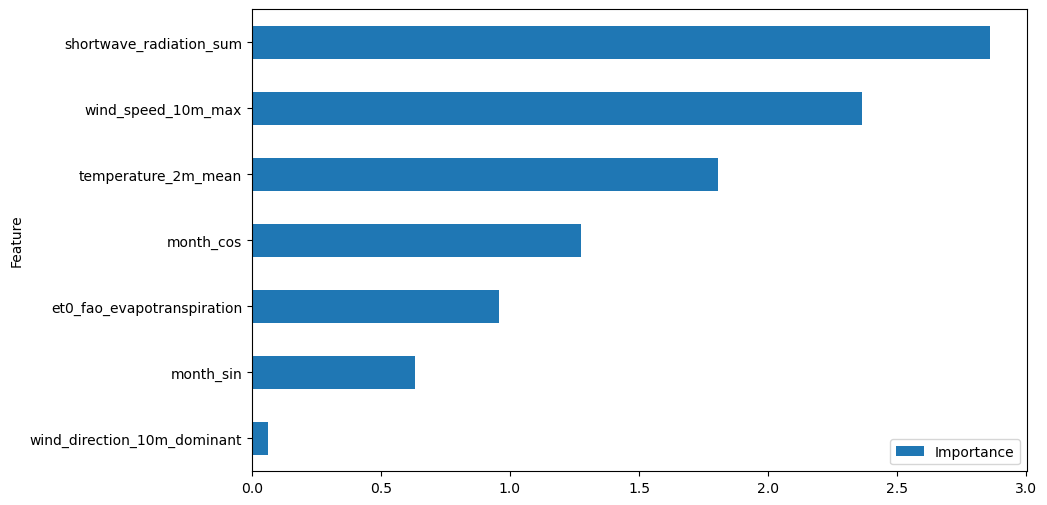

In [30]:
pipe_reg = make_pipeline(preprocess_reg, SVR(kernel='linear'))
pipe_reg.fit(X_train, y_train_regress)

coefficients = pipe_reg.named_steps['svr'].coef_[0]

feature_importance = pd.DataFrame({'Feature': numeric_features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Figure 5.  Feature importance obtained from the regression model.

For regression model on predicting the precipitation sum, the short wave radiation is the most important.

### 2.4.3 Hyperparameter optimization

In [31]:
np.logspace(-4, 3, 8)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [32]:
 np.logspace(-3, 2, 6)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [33]:
param_grid  = {
    'svr__C': np.logspace(-4, 3, 8),
    'svr__gamma': np.logspace(-3, 2, 6)
}

svr_pipe = make_pipeline(preprocess_reg, SVR())

svr_random_search = RandomizedSearchCV(svr_pipe, param_distributions=param_grid, n_iter=48, n_jobs=-1, return_train_score=True)
svr_random_search.fit(X_train, y_train_regress)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['temperature_2m_mean',
                                                                                'wind_speed_10m_max',
                                                                                'wind_direction_10m_dominant',
                                                                                'shortwave_radiation_sum',
                                                                                'et0_fao_evapotranspiration',
                                                                                'month_sin',
                                                                                'month_cos']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['month'])])),
                                             ('svr', SVR())]),
                   n_iter=48, n_jobs=-1,
                   param_distributions={'svr__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'svr__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                   return_train_score=True)

In [34]:
pd.DataFrame(svr_random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svr__C", 
        "param_svr__gamma",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score          1         2         3         4          5   \
mean_test_score    0.690549  0.676705   0.66236  0.646798   0.645143   
param_svr__C         1000.0     100.0      10.0      10.0      100.0   
param_svr__gamma        0.1       0.1       1.0       0.1        1.0   
mean_fit_time     42.648722  5.154029  3.539921  2.032748  21.799898   

rank_test_score         6         7         8         9         10  ...  \
mean_test_score   0.634887   0.61414  0.600894  0.571757  0.570221  ...   
param_svr__C        1000.0     100.0       1.0       1.0      10.0  ...   
param_svr__gamma      0.01      0.01       0.1       1.0      0.01  ...   
mean_fit_time     6.949708  2.569304  1.673115  1.757078  1.991625  ...   

rank_test_score         39        40        41        42        43        44  \
mean_test_score   -0.27585 -0.276582 -0.277221 -0.279047 -0.280389 -0.280391   
param_svr__C         0.001    0.0001       0.1    0.0001     0.001    0.0001   
param_svr__gamma     0.001      0.01     100.0       1.0      10.0     0.001   
mean_fit_time     2.035658  2.021533  2.260492  2.016566  1.875186  1.944372   

rank_test_score         45        46        47        48  
mean_test_score  -0.280398 -0.280832 -0.280847 -0.280892  
param_svr__C          0.01    0.0001     0.001    0.0001  
param_svr__gamma     100.0      10.0     100.0     100.0  
mean_fit_time     2.166539  1.879927   2.10599  2.044175  

[4 rows x 48 columns]

In [35]:
print('SVR Best Parameters:')
print(svr_random_search.best_params_)
print()
print('SVR Best Score:')
print(svr_random_search.best_score_)

SVR Best Parameters:
{'svr__gamma': 0.1, 'svr__C': 1000.0}

SVR Best Score:
0.690548539278994


In [36]:
best_pipe = make_pipeline(preprocess_reg, SVR(gamma=0.1, C=1000))
best_pipe.fit(X_train, y_train_regress)
best_pipe.score(X_test, y_test_regress)

0.6993869426812351

# 3. Discussion

The best classification model in our training and testing process is SVC-RBF with hyperparameter C=10.0. It yields the best test score of 0.8625 and f1-score of 0.87 on the positive class (precipitation occurs on the day) when generalizes to the unseen data. This is a pretty high accuracy to predict whether there's rain on a particular day. 

The best regression model trained with the same features to predict the amount of precipitaiton is SVR with gamma=0.1 and C=1000. The score on the unseen test data is 0.6993, which is adequate. This result suggest more study (e.g., adding new features) could be done to improve the regression model.

# References

[1] New, Mark, et al. "Precipitation measurements and trends in the twentieth century." International Journal of Climatology: A Journal of the Royal Meteorological Society 21.15 (2001): 1889-1922.

[2] Ortiz-García, E. G., S. Salcedo-Sanz, and C. Casanova-Mateo. "Accurate precipitation prediction with support vector classifiers: A study including novel predictive variables and observational data." Atmospheric research 139 (2014): 128-136.

[3] Zippenfenig, P. (2023). Open-Meteo.com Weather API [Computer software]. Zenodo. https://doi.org/10.5281/ZENODO.7970649

[4] Pal, Jeremy S., Eric E. Small, and Elfatih AB Eltahir. "Simulation of regional‐scale water and energy budgets: Representation of subgrid cloud and precipitation processes within RegCM." Journal of Geophysical Research: Atmospheres 105.D24 (2000): 29579-29594.
